# Deep Learning for tensiometry of pendant drop

### Import necessary packages and self-defined classes

In [1]:
# pyplot
import matplotlib.pyplot as plt
# pytorch
import torch
import torch.optim as optim
import torch.nn.functional as F  # useful stateless functions
# Test/Train data split
from functools import lru_cache
from torch.utils.data import DataLoader, Dataset
from torch.utils.data.sampler import SubsetRandomSampler
import numpy as np
import logging
# sklearn
from sklearn import preprocessing
# os
import os
# warnings
import warnings
warnings.filterwarnings('ignore')
# random
import random
# math
import math
import scipy.interpolate
# self-defined model
from model_pic import *
from model_cal import *
from model_one import *
import pandas as pd

#PictureNet
from PIL import Image
from skimage.io import imread
from sklearn.model_selection import train_test_split

## Dataset loading and preprocessing

In [2]:
class DataSplit:

    def __init__(self, dataset, test_train_split=0.9, val_train_split=0.1, shuffle=False):
        self.dataset = dataset

        dataset_size = len(dataset)
        self.indices = list(range(dataset_size))
        test_split = int(np.floor(test_train_split * dataset_size))

        if shuffle:
            np.random.shuffle(self.indices)

        train_indices, self.test_indices = self.indices[:test_split], self.indices[test_split:]
        train_size = len(train_indices)
        validation_split = int(np.floor((1 - val_train_split) * train_size))

        self.train_indices, self.val_indices = train_indices[:validation_split], train_indices[validation_split:]

        self.train_sampler = SubsetRandomSampler(self.train_indices)
        self.val_sampler = SubsetRandomSampler(self.val_indices)
        self.test_sampler = SubsetRandomSampler(self.test_indices)
    
    def get_train_split_point(self):
        return len(self.train_sampler) + len(self.val_indices)

    def get_validation_split_point(self):
        return len(self.train_sampler)

    @lru_cache(maxsize=4)
    def get_split(self, batch_size=64, num_workers=0):
        logging.debug('Initializing train-validation-test dataloaders')
        self.train_loader = self.get_train_loader(batch_size=batch_size, num_workers=num_workers)
        self.val_loader = self.get_validation_loader(batch_size=batch_size, num_workers=num_workers)
        self.test_loader = self.get_test_loader(batch_size=batch_size, num_workers=num_workers)
        return self.train_loader, self.val_loader, self.test_loader

    @lru_cache(maxsize=4)
    def get_train_loader(self, batch_size=64, num_workers=0):
        logging.debug('Initializing train dataloader')
        self.train_loader = DataLoader(self.dataset, batch_size=batch_size, sampler=self.train_sampler, shuffle=False, num_workers=num_workers)
        return self.train_loader

    @lru_cache(maxsize=4)
    def get_validation_loader(self, batch_size=64, num_workers=0):
        logging.debug('Initializing validation dataloader')
        self.val_loader = DataLoader(self.dataset, batch_size=batch_size, sampler=self.val_sampler, shuffle=False, num_workers=num_workers)
        return self.val_loader

    @lru_cache(maxsize=4)
    def get_test_loader(self, batch_size=64, num_workers=0):
        logging.debug('Initializing test dataloader')
        self.test_loader = DataLoader(self.dataset, batch_size=batch_size, sampler=self.test_sampler, shuffle=False, num_workers=num_workers)
        return self.test_loader

===================================

### Load data for PhysicsNet

In [3]:
data_matrix_points = pd.read_csv("Data_uniform/Edge_points.csv", header= None)
data_matrix_spline = pd.read_csv("Data_uniform/Spline.csv", header= None)
print(data_matrix_points)
# print(data_matrix_spline)

# Make the droplet dataset class based on data_matrix
class Droplet_data_set(Dataset):
    def __init__(self,dataInput):
        x = dataInput.iloc[0:,3:].values
        y = dataInput.iloc[0:,0:2].values
        # x = np.random.normal(x,0.01)
        y0 = dataInput.iloc[:,0].values
        y1 = dataInput.iloc[:,1].values
        
        # Plot surface tension histogram
        n, bins, patches = plt.hist(x=y0, bins='auto', color='#0504aa',
                                    alpha=0.7, rwidth=0.85)
        plt.grid(axis='y', alpha=0.75)
        plt.xlabel('Surface Tension[mN/m]')
        plt.ylabel('Frequency')
        plt.title('Occurence of data per Surface Tension')\

        # Plot volume histogram
        # n, bins, patches = plt.hist(x=y1, bins='auto', color='#0504aa',
        #                             alpha=0.7, rwidth=0.85)
        # plt.grid(axis='y', alpha=0.75)
        # plt.xlabel('Volume[mm^3]')
        # plt.ylabel('Frequency')
        # plt.title('Occurence of data per Volume')

        self.x_train = torch.tensor(x,dtype=torch.float32)
        self.y_train = torch.tensor(y,dtype=torch.float32)
        
    def __getitem__(self, idx):
        return self.x_train[idx],self.y_train[idx]
    
    def __len__(self):
         return len(self.y_train)
        

        0         1          2             3         4         5         6    \
0      15.1   5.10061  14.150364 -4.464245e-24  0.031518  0.062998  0.094404   
1      15.1   5.20122  13.846032  7.555379e-24  0.031876  0.063713  0.095474   
2      15.1   5.30183  13.542532  2.339297e-23  0.032235  0.064430  0.096546   
3      15.1   5.40244  13.239690 -1.287495e-23  0.032596  0.065149  0.097622   
4      15.1   5.50305  12.937316  2.640561e-25  0.032957  0.065871  0.098701   
...     ...       ...        ...           ...       ...       ...       ...   
24742  86.1  25.28098  68.539411  9.590440e-26  0.062687  0.125280  0.187688   
24743  86.1  25.81469  67.593048 -1.411544e-26  0.063329  0.126561  0.189606   
24744  86.1  26.34840  66.662881 -2.293179e-25  0.063968  0.127837  0.191515   
24745  86.1  26.88211  65.747951 -1.514069e-24  0.064605  0.129108  0.193416   
24746  86.1  27.41582  64.847338 -7.083356e-25  0.065239  0.130375  0.195312   

            7         8         9    ..

Create and splite the dataset for edge point model

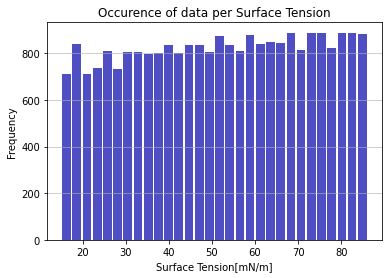

In [4]:
my_data_set_points = Droplet_data_set(data_matrix_points)
split_points = DataSplit(my_data_set_points, shuffle=True)  # Split the single dataset into 3 datasets for training, test and validation.
train_loader_points, val_loader_points, test_loader_points = split_points.get_split(batch_size=512, num_workers=0)

Create and splite the dataset for spline model

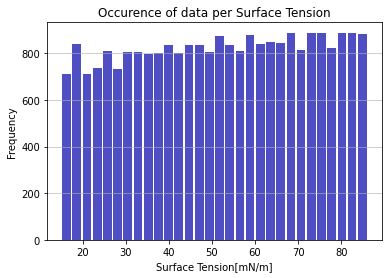

In [5]:
my_data_set_spline = Droplet_data_set(data_matrix_spline)
split_spline = DataSplit(my_data_set_spline, shuffle=True)  # Split the single dataset into 3 datasets for training, test and validation.
train_loader_spline, val_loader_spline, test_loader_spline = split_spline.get_split(batch_size=512, num_workers=0)

===========================================

### Load data for PictureNet
Read image from files

In [6]:
train_img = []
data_matrix_points = pd.read_csv("Data_uniform/Edge_points.csv", header= None)
data_matrix_spline = pd.read_csv("Data_uniform/Spline.csv", header= None)
data_image_points = data_matrix_points  
data_image_spline = data_matrix_spline

for img_name in data_image_points.iloc[0:,3:].index + 1:      # modify the number depends on size of dataset
    # defining the image path
    image_path = 'Data_uniform/' + str(img_name) + '.png'      # modify the path depends on which dataset
    # reading the image
    img = imread(image_path, as_gray=True)
    img = img[4:-4, 4:-4]  #crop 
    # normalizing the pixel values
    img /= 255.0
    # converting the type of pixel to float 32
    img = img.astype('float32')
    # appending the image into the list
    train_img.append(img)

Plot a single image for viewing

Current image = 5313
Picture size = (82, 77)


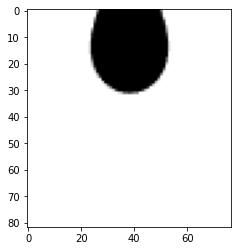

In [7]:
rand = random.randint(1, 24746)
print("Current image =", rand)
print("Picture size =", train_img[rand].shape)
plt.imshow(train_img[rand], cmap='gray')


Define the function

In [8]:
# Split and transfer the data from list to torch format
def split_n_transfer(x, y):
    # Points data split
    train_x_pic, rem_x_pic, train_y_pic, rem_y_pic = train_test_split(x, y, test_size = 0.2)    # default shuffle = True
    val_x_pic, test_x_pic, val_y_pic, test_y_pic = train_test_split(rem_x_pic, rem_y_pic, test_size = 0.5)

    # converting the train images of points and targets into torch format
    train_x_pic = train_x_pic.reshape(len(train_x_pic), 1, 82, 77)
    train_x_pic = torch.from_numpy(train_x_pic)
    train_y_pic = torch.from_numpy(train_y_pic)

    # converting the val images and target points into torch format
    val_x_pic = val_x_pic.reshape(len(val_x_pic), 1, 82, 77)
    val_x_pic = torch.from_numpy(val_x_pic)
    val_y_pic = torch.from_numpy(val_y_pic)
    # print(val_x_pic.shape, val_y_pic.shape)

    # converting the test images and targets into torch format for points
    test_x_pic = test_x_pic.reshape(len(test_x_pic), 1, 82, 77)
    test_x_pic  = torch.from_numpy(test_x_pic)
    test_y_pic = torch.from_numpy(test_y_pic)
    # print(test_x_pic.shape, test_y_pic.shape)
    
    return train_x_pic, train_y_pic, val_x_pic, val_y_pic, test_x_pic, test_y_pic

# converting the dataset into mini-batch dataset (input 4D -> 5D and 2D -> 3D)
def batch_transform(dataset, batch_size=512):
    batch = []
    batch_num = math.ceil(len(dataset)/batch_size)
    for i in range(batch_num):
        if len(dataset) == 4:
            if i < batch_num-1:
                batch.append(dataset[i*batch_size:(i+1)*batch_size, :, :, :])
            else:
                batch.append(dataset[i*batch_size:, :, :, :])
        else:
            if i < batch_num-1:
                batch.append(dataset[i*batch_size:(i+1)*batch_size, :])
            else:
                batch.append(dataset[i*batch_size:, :])
    return batch

# converting all raw datasets into batch datasets in the same time
def batch_all(train_x, train_y, val_x, val_y, test_x, test_y):
    train_x_pic = batch_transform(train_x)
    train_y_pic = batch_transform(train_y)
    val_x_pic = batch_transform(val_x)
    val_y_pic = batch_transform(val_y)
    test_x_pic = batch_transform(test_x)
    test_y_pic = batch_transform(test_y)
    return train_x_pic, train_y_pic, val_x_pic, val_y_pic, test_x_pic, test_y_pic

Create and splite the dataset for edge point model

In [9]:
# converting the list to numpy array
train_x_pic = np.array(train_img)
train_y_pic_points = data_image_points.iloc[0:,3:].values

train_x_pic_points, train_y_pic_points, val_x_pic_points, val_y_pic_points, test_x_pic_points, test_y_pic_points = \
    split_n_transfer(train_x_pic, train_y_pic_points)

train_x_pic_points, train_y_pic_points, val_x_pic_points, val_y_pic_points, test_x_pic_points, test_y_pic_points = \
    batch_all(train_x_pic_points, train_y_pic_points, val_x_pic_points, val_y_pic_points, test_x_pic_points, test_y_pic_points)
    
print(len(train_x_pic_points), len(train_y_pic_points), len(val_x_pic_points), len(val_y_pic_points), len(test_x_pic_points), len(test_y_pic_points))


39 39 5 5 5 5


Create and splite the dataset for spline model

In [10]:
# converting the list to numpy array
train_x_pic = np.array(train_img)
train_y_pic_spline = data_image_spline.iloc[0:,3:].values

train_x_pic_spline, train_y_pic_spline, val_x_pic_spline, val_y_pic_spline, test_x_pic_spline, test_y_pic_spline = \
    split_n_transfer(train_x_pic, train_y_pic_spline)

train_x_pic_spline, train_y_pic_spline, val_x_pic_spline, val_y_pic_spline, test_x_pic_spline, test_y_pic_spline = \
    batch_all(train_x_pic_spline, train_y_pic_spline, val_x_pic_spline, val_y_pic_spline, test_x_pic_spline, test_y_pic_spline)

print(len(train_x_pic_spline), len(train_y_pic_spline), len(val_x_pic_spline), len(val_y_pic_spline), len(test_x_pic_spline), len(test_y_pic_spline))

39 39 5 5 5 5


Create and splite the dataset for <font color=red>one-model solution</font>

In [11]:
# converting the list to numpy array
train_x_one = np.array(train_img)
train_y_one = data_image_points.iloc[0:,0:2].values

train_x_one, train_y_one, val_x_one, val_y_one, test_x_one, test_y_one = \
    split_n_transfer(train_x_one, train_y_one)

train_x_one, train_y_one, val_x_one, val_y_one, test_x_one, test_y_one = \
    batch_all(train_x_one, train_y_one, val_x_one, val_y_one, test_x_one, test_y_one)

print(len(train_x_one), len(train_y_one), len(val_x_one), len(val_y_one), len(test_x_one), len(test_y_one))

39 39 5 5 5 5


==============================

### Deside to apply host or device


In [14]:
USE_GPU = True
if USE_GPU and torch.cuda.is_available():
    device = torch.device('cuda')
else:
    device = torch.device('cpu')
print(device)

cuda


## Define the functions for models

In [15]:
def loss_cal_phiysics(loss_list, model, loader):
    model.eval()  # set model to evaluation mode
    with torch.no_grad():
        loss_epoch = 0
        for t, (x, y) in enumerate(loader):
            x = x.to(device=device, dtype=torch.float32)  # move to device, e.g. GPU
            y = y.to(device=device, dtype=torch.float32)
            scores = model(x)
            loss = F.mse_loss(scores, y)
            loss_epoch += loss
        loss_list.append(loss_epoch.cpu().data.numpy()/t)

def loss_cal_picture(loss_list, model, x_dataset, y_dataset):
    model.eval()  # set model to evaluation mode
    with torch.no_grad():
        loss_epoch = 0
        for t in range(len(x_dataset)):
            x = x_dataset[t]
            y = y_dataset[t]
            x = x.to(device=device, dtype=torch.float32)  # move to device, e.g. GPU
            y = y.to(device=device, dtype=torch.float32)
            scores = model(x)
            loss = F.mse_loss(scores, y)
            loss_epoch += loss
        loss_list.append(loss_epoch.cpu().data.numpy()/t)

def prediction(model, x):   # only a batch
    model = model.to(device=device)
    model.eval()  # set model to evaluation mode
    with torch.no_grad():
        x = x.to(device=device, dtype=torch.float32)
        score = torch.Tensor.cpu(model(x))
    return score

def model_selection(model, path, loss, epoch_current, epoch_ref, loss_ref):
    loss_best = loss_ref
    epoch_best = epoch_ref
    if epoch_current == 0 and ~(os.path.isdir(path)):
            loss_current = loss[epoch_current]
            loss_best = loss[epoch_current]
            torch.save(model, path)
    else:
        loss_current = loss[epoch_current]
        if loss_current <= (loss_best * 1.1):   # 10% margin to get better fitting but a bit more loss
            loss_best = loss_current
            epoch_best = epoch_current
            torch.save(model, path)
    return loss_best, epoch_best

def train_physics(model, optimizer, epochs=1, model_input=0):
    loss_train = []
    loss_val = []
    loss_best = 0
    epoch_best = 0
    
    # model selection depends on data type
    if model_input == 0:
        train_loader = train_loader_points
        val_loader = val_loader_points
        PATH_CAL = os.path.join(os.getcwd(), "model_cal_points.pt")
    elif model_input == 1:
        train_loader = train_loader_spline
        val_loader = val_loader_spline
        PATH_CAL = os.path.join(os.getcwd(), "model_cal_spline.pt")
    else:
        ValueError("Incorrect input: 0 for edge point model, 1 for spline model")

    model = model.to(device=device)  # move the model parameters to CPU/GPU
    for e in range(epochs):
        for _, (x, y) in enumerate(train_loader):
            x = x.reshape(len(x), 1, 1, -1)     # reshape to 4D data for formal input of model
            model.train()  # put model to training mode
            x = x.to(device=device, dtype=torch.float32)  # move to device, e.g. GPU
            y = y.to(device=device, dtype=torch.float32)
            scores = model(x)
            loss = F.mse_loss(scores, y)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
        loss_cal_phiysics(loss_train, model, train_loader)
        loss_cal_phiysics(loss_val, model, val_loader)
        print('epoch %d: train_loss = %.4f, val_loss = %.4f' % (e+1, loss_train[e], loss_val[e]))

        # selecting the best model to save
        loss_best, epoch_best = model_selection(model, PATH_CAL, loss_train, e, epoch_best, loss_best)
    
    print("The model is saved at epoch =", epoch_best+1, "and the loss =", loss_best.item())
    
    x = range(1, epochs+1)

    plt.semilogy(x, loss_train, 'b-', label="training loss")
    plt.semilogy(x, loss_val, 'r--', label="validation loss")
    plt.xlabel("Epochs")
    plt.ylabel("MSE Loss")
    plt.title("Train/Validation Loss")
    plt.legend()
    plt.show()

def train_picture(model, optimizer, epochs=1, model_input=0):
    loss_train = []
    loss_val = []
    loss_best = 0
    epoch_best = 0

    # model selection depends on data type
    if model_input == 0:
        train_x_pic = train_x_pic_points
        train_y_pic = train_y_pic_points
        val_x_pic = val_x_pic_points
        val_y_pic = val_y_pic_points
        PATH_PIC = os.path.join(os.getcwd(), "model_pic_points.pt")
    elif model_input == 1:
        train_x_pic = train_x_pic_spline
        train_y_pic = train_y_pic_spline
        val_x_pic = val_x_pic_spline
        val_y_pic = val_y_pic_spline
        PATH_PIC = os.path.join(os.getcwd(), "model_pic_spline.pt")
    else:
        ValueError("Incorrect input: 0 for edge point model, 1 for spline model")

    model = model.to(device=device)  # move the model parameters to CPU/GPU
    for e in range(epochs):
        for t in range(len(train_x_pic)):
            model.train()  # put model to training mode
            x = train_x_pic[t]
            y = train_y_pic[t]
            x = x.to(device=device, dtype=torch.float32)  # move to device, e.g. GPU
            y = y.to(device=device, dtype=torch.float32)

            scores = model(x)
            loss = F.mse_loss(scores, y)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
        loss_cal_picture(loss_train, model, train_x_pic, train_y_pic)
        loss_cal_picture(loss_val, model, val_x_pic, val_y_pic)
        print('epoch %d: train_loss = %.4f, val_loss = %.4f' % (e+1, loss_train[e], loss_val[e]))
        
        # selecting the best model to save
        loss_best, epoch_best = model_selection(model, PATH_PIC, loss_train, e, epoch_best, loss_best)
    
    print("The model is saved at epoch =", epoch_best+1, "and the loss =", loss_best.item())

    x = range(1, epochs+1)

    plt.semilogy(x, loss_train, 'b-', label="training loss")
    plt.semilogy(x, loss_val, 'r--', label="validation loss")
    plt.xlabel("Epochs")
    plt.ylabel("MSE Loss")
    plt.title("Train/Validation Loss")
    plt.legend()
    plt.show()

def train_united(model, optimizer, epochs=1):
    loss_train = []
    loss_val = []
    loss_best = 0
    epoch_best = 0

    PATH_ONE = os.path.join(os.getcwd(), "model_one.pt")

    model = model.to(device=device)  # move the model parameters to CPU/GPU
    for e in range(epochs):
        for t in range(len(train_x_one)):
            model.train()  # put model to training mode
            x = train_x_one[t]
            y = train_y_one[t]
            x = x.to(device=device, dtype=torch.float32)  # move to device, e.g. GPU
            y = y.to(device=device, dtype=torch.float32)

            scores = model(x)
            loss = F.mse_loss(scores, y)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
        loss_cal_picture(loss_train, model, train_x_one, train_y_one)
        loss_cal_picture(loss_val, model, val_x_one, val_y_one)
        print('epoch %d: train_loss = %.4f, val_loss = %.4f' % (e+1, loss_train[e], loss_val[e]))
        
        # selecting the best model to save
        loss_best, epoch_best = model_selection(model, PATH_ONE, loss_train, e, epoch_best, loss_best)
    
    print("The model is saved at epoch =", epoch_best+1, "and the loss =", loss_best.item())

    x = range(1, epochs+1)

    plt.semilogy(x, loss_train, 'b-', label="training loss")
    plt.semilogy(x, loss_val, 'r--', label="validation loss")
    plt.xlabel("Epochs")
    plt.ylabel("MSE Loss")
    plt.title("Train/Validation Loss")
    plt.legend()
    plt.show()


## Train UnitedNet

epoch 1: train_loss = 1813.6920, val_loss = 2209.4421
epoch 2: train_loss = 1785.7712, val_loss = 2175.4136
epoch 3: train_loss = 1772.3053, val_loss = 2158.7449
epoch 4: train_loss = 1125.4975, val_loss = 1371.7454
epoch 5: train_loss = 1416.7346, val_loss = 1726.2739
epoch 6: train_loss = 700.6707, val_loss = 854.4402
epoch 7: train_loss = 1194.1712, val_loss = 1455.3944
epoch 8: train_loss = 945.4078, val_loss = 1151.9706
epoch 9: train_loss = 545.3555, val_loss = 665.2946
epoch 10: train_loss = 1214.7199, val_loss = 1481.9177
epoch 11: train_loss = 505.9311, val_loss = 617.0729
epoch 12: train_loss = 675.1877, val_loss = 823.8127
epoch 13: train_loss = 677.3917, val_loss = 826.8779
epoch 14: train_loss = 388.4220, val_loss = 473.4984
epoch 15: train_loss = 1100.9758, val_loss = 1341.3293
epoch 16: train_loss = 341.7446, val_loss = 417.8947
epoch 17: train_loss = 482.5013, val_loss = 587.9653
epoch 18: train_loss = 314.2792, val_loss = 382.9341
epoch 19: train_loss = 576.0203, val_l

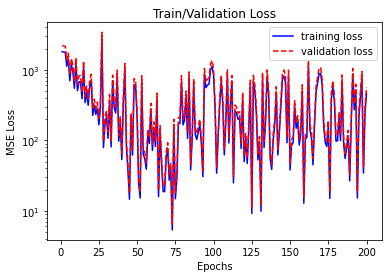

In [20]:
learning_rate = 1e-3

model_one = UnitedNet()
optimizer = optim.Adam(model_one.parameters(), lr=learning_rate)
epoch = 200

train_united(model_one, optimizer, epoch)

Retrain UnitedNet with SGD

epoch 1: train_loss = 0.8959, val_loss = 1.1000
epoch 2: train_loss = 0.8667, val_loss = 1.0635
epoch 3: train_loss = 0.8393, val_loss = 1.0280
epoch 4: train_loss = 0.8280, val_loss = 1.0131
epoch 5: train_loss = 0.8180, val_loss = 1.0052
epoch 6: train_loss = 0.8035, val_loss = 0.9862
epoch 7: train_loss = 0.7925, val_loss = 0.9711
epoch 8: train_loss = 0.7849, val_loss = 0.9640
epoch 9: train_loss = 0.7935, val_loss = 0.9722
epoch 10: train_loss = 0.7901, val_loss = 0.9724
epoch 11: train_loss = 0.7851, val_loss = 0.9636
epoch 12: train_loss = 0.7878, val_loss = 0.9701
epoch 13: train_loss = 0.7717, val_loss = 0.9479
epoch 14: train_loss = 0.7707, val_loss = 0.9448
epoch 15: train_loss = 0.7794, val_loss = 0.9549
epoch 16: train_loss = 0.7744, val_loss = 0.9515
epoch 17: train_loss = 0.7770, val_loss = 0.9566
epoch 18: train_loss = 0.7785, val_loss = 0.9550
epoch 19: train_loss = 0.7667, val_loss = 0.9444
epoch 20: train_loss = 0.7657, val_loss = 0.9399
epoch 21: train_loss = 0.7655

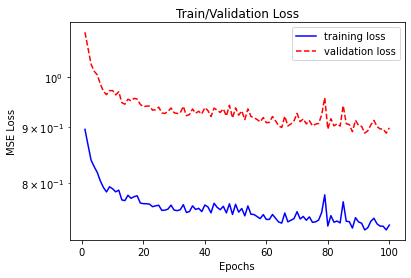

In [22]:
PATH_ONE = os.path.join(os.getcwd(), "model_one.pt")

model_one_trained = torch.load(PATH_ONE)

learning_rate = 3e-4

optimizer = optim.SGD(model_one_trained.parameters(), lr=learning_rate)
epoch = 100

# 0 indicates edge points 1 indicates spline
train_united(model_one_trained, optimizer, epoch)

## Train PhysicsNet Edge Points

epoch 1: train_loss = 1755.4799, val_loss = 2286.3327
epoch 2: train_loss = 1719.5151, val_loss = 2236.6938
epoch 3: train_loss = 1673.8610, val_loss = 2175.5612
epoch 4: train_loss = 1625.6211, val_loss = 2116.3861
epoch 5: train_loss = 1543.5547, val_loss = 2011.3470
epoch 6: train_loss = 1499.5812, val_loss = 1951.5016
epoch 7: train_loss = 1356.9593, val_loss = 1762.3306
epoch 8: train_loss = 1281.2953, val_loss = 1669.1803
epoch 9: train_loss = 1262.9352, val_loss = 1646.6193
epoch 10: train_loss = 1205.4920, val_loss = 1571.2340
epoch 11: train_loss = 965.1520, val_loss = 1255.9427
epoch 12: train_loss = 905.4530, val_loss = 1174.6116
epoch 13: train_loss = 996.8525, val_loss = 1302.9124
epoch 14: train_loss = 838.6210, val_loss = 1096.7214
epoch 15: train_loss = 816.5716, val_loss = 1069.0780
epoch 16: train_loss = 795.1847, val_loss = 1041.6711
epoch 17: train_loss = 721.9854, val_loss = 946.3671
epoch 18: train_loss = 512.9257, val_loss = 664.9910
epoch 19: train_loss = 519.80

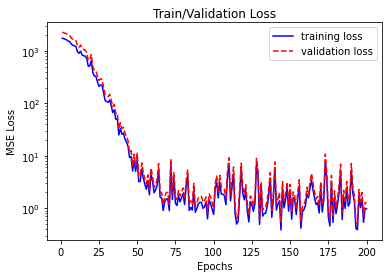

In [29]:
in_channel = 160
node_1 = 512
node_2 = 512
node_3 = 256
node_4 = 256
node_5 = 64
node_6 = 16
out_channel = 2

learning_rate = 1e-3

model_physics = PhysicsNet(in_channel, node_1, node_2, node_3, node_4, node_5, node_6, out_channel)
optimizer = optim.Adam(model_physics.parameters(), lr=learning_rate)
epoch = 200

# 0 indicates edge points 1 indicates spline
train_physics(model_physics, optimizer, epoch, 0)

## Train PhysicsNet spline

epoch 1: train_loss = 1797.6878, val_loss = 2296.8521
epoch 2: train_loss = 1754.7517, val_loss = 2245.6248
epoch 3: train_loss = 1705.9983, val_loss = 2181.6217
epoch 4: train_loss = 1667.4437, val_loss = 2134.5820
epoch 5: train_loss = 1638.2040, val_loss = 2097.6162
epoch 6: train_loss = 1598.4022, val_loss = 2048.0736
epoch 7: train_loss = 1508.1242, val_loss = 1929.3332
epoch 8: train_loss = 1389.3698, val_loss = 1782.7248
epoch 9: train_loss = 1214.1033, val_loss = 1553.9202
epoch 10: train_loss = 1234.2863, val_loss = 1583.4373
epoch 11: train_loss = 1227.8232, val_loss = 1572.1777
epoch 12: train_loss = 1147.0360, val_loss = 1473.6130
epoch 13: train_loss = 1039.9303, val_loss = 1336.8972
epoch 14: train_loss = 857.3400, val_loss = 1098.2113
epoch 15: train_loss = 854.9539, val_loss = 1100.3111
epoch 16: train_loss = 756.2164, val_loss = 968.8101
epoch 17: train_loss = 736.2629, val_loss = 942.3599
epoch 18: train_loss = 623.8765, val_loss = 798.8366
epoch 19: train_loss = 664.

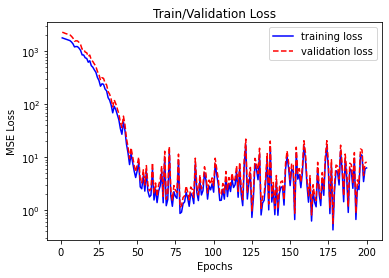

In [32]:
in_channel = 22
node_1 = 512
node_2 = 512
node_3 = 256
node_4 = 256
node_5 = 64
node_6 = 16
out_channel = 2

learning_rate = 1e-3

model_physics = PhysicsNet(in_channel, node_1, node_2, node_3, node_4, node_5, node_6, out_channel)
optimizer = optim.Adam(model_physics.parameters(), lr=learning_rate)
epoch = 200

# 0 indicates edge points 1 indicates spline
train_physics(model_physics, optimizer, epoch, 1)

<font color=red>
It seems like more points we have, small oscillation we get.<br>
Instead of taking the polynomial coefficients as input, transfer coefficients into points.
</font>

### Retrain with SGD

epoch 1: train_loss = 0.5665, val_loss = 0.7323
epoch 2: train_loss = 0.6558, val_loss = 0.8578
epoch 3: train_loss = 0.3804, val_loss = 0.4894
epoch 4: train_loss = 0.2882, val_loss = 0.3644
epoch 5: train_loss = 0.4603, val_loss = 0.6030
epoch 6: train_loss = 1.3191, val_loss = 1.7214
epoch 7: train_loss = 0.2866, val_loss = 0.3679
epoch 8: train_loss = 0.3429, val_loss = 0.4438
epoch 9: train_loss = 0.7591, val_loss = 0.9938
epoch 10: train_loss = 0.9989, val_loss = 1.2795
epoch 11: train_loss = 0.2577, val_loss = 0.3311
epoch 12: train_loss = 0.1676, val_loss = 0.2164
epoch 13: train_loss = 0.2848, val_loss = 0.3693
epoch 14: train_loss = 0.4207, val_loss = 0.5432
epoch 15: train_loss = 0.2552, val_loss = 0.3322
epoch 16: train_loss = 0.5360, val_loss = 0.7035
epoch 17: train_loss = 0.2294, val_loss = 0.2948
epoch 18: train_loss = 1.3623, val_loss = 1.7615
epoch 19: train_loss = 1.8126, val_loss = 2.3575
epoch 20: train_loss = 0.2189, val_loss = 0.2861
epoch 21: train_loss = 0.3071

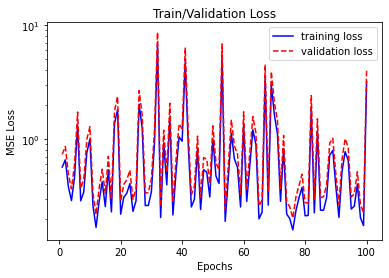

In [33]:
# PATH_CAL = os.path.join(os.getcwd(), "model_cal_points.pt")
PATH_CAL = os.path.join(os.getcwd(), "model_cal_spline.pt")

model_physics_trained = torch.load(PATH_CAL)

learning_rate = 3e-4

optimizer = optim.SGD(model_physics_trained.parameters(), lr=learning_rate)
epoch = 100

# 0 indicates edge points 1 indicates spline
train_physics(model_physics_trained, optimizer, epoch, 1)

### Visualization of outcomes

United Model

In [16]:
PATH_ONE = os.path.join(os.getcwd(), "model_one.pt")

model_one_trained = torch.load(PATH_ONE)

rand = random.randint(0, len(test_x_one)-1)

x = test_x_one[rand]
y = test_y_one[rand]

score_example_one = prediction(model_one_trained, x)

# Print only 8 data samples for comparison
print("Ground Truths     =", y[:8])
print("Prediction Points =", score_example_one[:8].reshape(8, 2))

Ground Truths     = tensor([[47.5000, 21.4037],
        [52.0000, 22.5878],
        [15.9000,  6.6878],
        [64.9000, 19.9624],
        [84.1000, 34.2046],
        [55.9000, 22.8240],
        [32.3000, 13.4267],
        [79.7000, 38.1429]], dtype=torch.float64)
Prediction Points = tensor([[48.0644, 21.3256],
        [52.0227, 22.8627],
        [16.7252,  6.4845],
        [65.2330, 19.5851],
        [83.1946, 34.5092],
        [56.6014, 23.6858],
        [33.1418, 12.1231],
        [80.6473, 37.2875]])


Edge Point Model

In [17]:
PATH_CAL_POINTS = os.path.join(os.getcwd(), "model_cal_points.pt")

model_physics_trained_points = torch.load(PATH_CAL_POINTS)

examples = enumerate(test_loader_points)
_, (x_test_points, y_test_points) = next(examples)

score_example_points = prediction(model_physics_trained_points, x_test_points)

# Print only 8 data samples for comparison
print("Ground Truths     =", y_test_points[:8])
print("Prediction Points =", score_example_points[:8].reshape(8, 2))

Ground Truths     = tensor([[17.6000,  5.4634],
        [30.4000, 10.4303],
        [74.8000, 28.7038],
        [55.0000, 25.2960],
        [30.9000, 13.8645],
        [61.4000, 29.1315],
        [29.2000,  8.1725],
        [49.9000, 20.0187]])
Prediction Points = tensor([[17.3690,  5.8746],
        [30.5696, 10.4206],
        [74.4721, 28.5513],
        [54.7781, 25.1124],
        [30.9303, 13.6345],
        [61.7149, 28.7648],
        [29.5324,  8.7688],
        [50.5629, 20.0785]])


Spline Model

In [18]:
PATH_CAL_SPLINE = os.path.join(os.getcwd(), "model_cal_spline.pt")

model_physics_trained_spline = torch.load(PATH_CAL_SPLINE)

examples = enumerate(test_loader_spline)
_, (x_test_spline, y_test_spline) = next(examples)

score_example_spline = prediction(model_physics_trained_spline, x_test_spline)

# Print only 8 data samples for comparison
print("Ground Truths     =", y_test_spline[:8])
print("Prediction Spline =", score_example_spline[:8].reshape(8, 2))

Ground Truths     = tensor([[61.2000, 16.4546],
        [74.5000, 22.5921],
        [48.9000, 15.7376],
        [36.0000, 13.2116],
        [50.1000, 15.9938],
        [32.9000, 11.9033],
        [25.9000,  8.1633],
        [37.2000,  9.9438]])
Prediction Spline = tensor([[60.9819, 16.5399],
        [74.9739, 22.2367],
        [48.4620, 15.5874],
        [36.3618, 13.1433],
        [49.7428, 15.9023],
        [33.2470, 12.1613],
        [26.5618,  8.1537],
        [37.2938, 10.7751]])


### Apply objective standard to evaluate tension prediction
<font color=red>Set up error margin and apply scoreuracy standard</font>

In [19]:
# get all testing data in torch format
x_test_points = split_points.dataset.x_train[split_points.test_sampler.indices]
y_test_points = split_points.dataset.y_train[split_points.test_sampler.indices]
x_test_spline = split_spline.dataset.x_train[split_spline.test_sampler.indices]
y_test_spline = split_spline.dataset.y_train[split_spline.test_sampler.indices]
# transfer from batches back into one
for i in range(len(test_x_one)):
    if i == 0:
        x_test_one = test_x_one[i]
        y_test_one = test_y_one[i]
        counter = True
    else:
        x_test_one = torch.cat([x_test_one, test_x_one[i]], dim=0)
        y_test_one = torch.cat([y_test_one, test_y_one[i]], dim=0)

print(x_test_points.shape, x_test_spline.shape, x_test_one.shape)
print(y_test_points.shape, y_test_spline.shape, y_test_one.shape)

torch.Size([2475, 160]) torch.Size([2475, 22]) torch.Size([2475, 1, 82, 77])
torch.Size([2475, 2]) torch.Size([2475, 2]) torch.Size([2475, 2])


In [20]:
# load models
PATH_CAL_SPLINE = os.path.join(os.getcwd(), "model_cal_spline.pt")
PATH_CAL_POINTS = os.path.join(os.getcwd(), "model_cal_points.pt")
PATH_ONE = os.path.join(os.getcwd(), "model_one.pt")
model_physics_trained_spline = torch.load(PATH_CAL_SPLINE, map_location='cpu')
model_physics_trained_points = torch.load(PATH_CAL_POINTS, map_location='cpu')
model_one_trained = torch.load(PATH_ONE, map_location='cpu')

# predict
pred_test_points = model_physics_trained_points(x_test_points)
pred_test_spline = model_physics_trained_spline(x_test_spline)
pred_test_one = model_one_trained(x_test_one)

Score of points prediction (two-model solution) = [0.803636372089386, 0.935757577419281, 0.9587878584861755, 0.9733333587646484, 0.9834343194961548]
Score of spline parameter prediction (two-model solution) = [0.7587878704071045, 0.9256565570831299, 0.962020218372345, 0.9822221994400024, 0.9907070994377136]
Score of united prediction (one-model solution) = [0.585454523563385, 0.8189898729324341, 0.9062626361846924, 0.943838357925415, 0.9632323384284973]


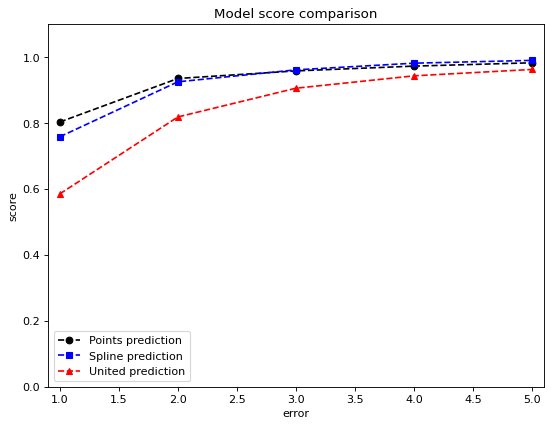

In [146]:
# set error margin to count as accurate
error_list = torch.linspace(0.01, 0.05, steps=5)
# error = 0.01

def score_cal(x, y, error):
    diff = ~abs((x-y)/y).gt(error) 
    count = diff[:, 0]
    return count.sum()/len(count)

score_list_points = []
score_list_spline = []
score_list_united = []
for i in range(5):
    score_list_points.append(score_cal(pred_test_points, y_test_points, error_list[i]).item())
    score_list_spline.append(score_cal(pred_test_spline, y_test_spline, error_list[i]).item())
    score_list_united.append(score_cal(pred_test_one, y_test_one, error_list[i]).item())

plt.figure(figsize=(8, 6), dpi=80)
plt.plot(error_list*100 ,score_list_points, 'ok--', label='Points prediction')
plt.plot(error_list*100 ,score_list_spline, 'sb--', label='Spline prediction')
plt.plot(error_list*100 ,score_list_united, '^r--', label='United prediction')
plt.axis([0.9, 5.1, 0, 1.1])
plt.xlabel('error')
plt.ylabel('score')
plt.title('Model score comparison')
plt.legend()
# print("Score of points prediction (two-model solution) =", score_list_points) 
# print("Score of spline parameter prediction (two-model solution) =", score_list_spline)
# print("Score of united prediction (one-model solution) =", score_list_united)

## Train PictureNet edge points

epoch 1: train_loss = 0.2720, val_loss = 0.3385
epoch 2: train_loss = 0.2495, val_loss = 0.3098
epoch 3: train_loss = 0.1071, val_loss = 0.1331
epoch 4: train_loss = 0.0481, val_loss = 0.0585
epoch 5: train_loss = 0.0893, val_loss = 0.1095
epoch 6: train_loss = 0.0369, val_loss = 0.0450
epoch 7: train_loss = 0.1478, val_loss = 0.1817
epoch 8: train_loss = 0.0121, val_loss = 0.0150
epoch 9: train_loss = 0.0033, val_loss = 0.0041
epoch 10: train_loss = 0.0040, val_loss = 0.0050
epoch 11: train_loss = 0.0034, val_loss = 0.0043
epoch 12: train_loss = 0.1285, val_loss = 0.1576
epoch 13: train_loss = 0.0378, val_loss = 0.0456
epoch 14: train_loss = 0.0178, val_loss = 0.0219
epoch 15: train_loss = 0.3274, val_loss = 0.3996
epoch 16: train_loss = 0.0153, val_loss = 0.0188
epoch 17: train_loss = 0.0451, val_loss = 0.0552
epoch 18: train_loss = 0.0221, val_loss = 0.0270
epoch 19: train_loss = 0.3605, val_loss = 0.4455
epoch 20: train_loss = 0.0098, val_loss = 0.0120
epoch 21: train_loss = 0.1722

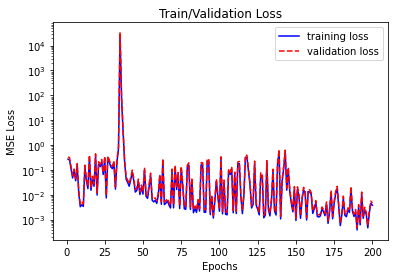

In [77]:
in_channel = 1
channel_1 = 16
channel_2 = 32
channel_3 = 64
node_1 = 1024
node_2 = 1024
out_channel = 160

learning_rate = 1e-3

model_picture = PictureNet(in_channel, channel_1, channel_2, channel_3, node_1, node_2, out_channel)
optimizer = optim.Adam(model_picture.parameters(), lr=learning_rate)
epoch = 200

# 0 indicates edge points 1 indicates spline
train_picture(model_picture, optimizer, epoch, 0)

## Train PictureNet for spline

epoch 1: train_loss = 0.6271, val_loss = 0.7661
epoch 2: train_loss = 0.3346, val_loss = 0.4115
epoch 3: train_loss = 0.0275, val_loss = 0.0340
epoch 4: train_loss = 0.0111, val_loss = 0.0136
epoch 5: train_loss = 0.0038, val_loss = 0.0047
epoch 6: train_loss = 0.0111, val_loss = 0.0135
epoch 7: train_loss = 0.0016, val_loss = 0.0020
epoch 8: train_loss = 0.0016, val_loss = 0.0020
epoch 9: train_loss = 0.0051, val_loss = 0.0062
epoch 10: train_loss = 0.0066, val_loss = 0.0081
epoch 11: train_loss = 0.0017, val_loss = 0.0020
epoch 12: train_loss = 0.0007, val_loss = 0.0009
epoch 13: train_loss = 0.0018, val_loss = 0.0022
epoch 14: train_loss = 0.0054, val_loss = 0.0066
epoch 15: train_loss = 0.0063, val_loss = 0.0078
epoch 16: train_loss = 0.0056, val_loss = 0.0069
epoch 17: train_loss = 0.0051, val_loss = 0.0062
epoch 18: train_loss = 0.0026, val_loss = 0.0031
epoch 19: train_loss = 0.0219, val_loss = 0.0267
epoch 20: train_loss = 0.0069, val_loss = 0.0085
epoch 21: train_loss = 0.0011

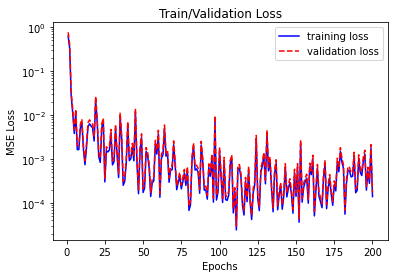

In [78]:
in_channel = 1
channel_1 = 16
channel_2 = 32
channel_3 = 64
node_1 = 1024
node_2 = 1024
out_channel = 22

learning_rate = 1e-3

model_picture = PictureNet(in_channel, channel_1, channel_2, channel_3, node_1, node_2, out_channel)
optimizer = optim.Adam(model_picture.parameters(), lr=learning_rate)
epoch = 200

# 0 indicates edge points 1 indicates spline
train_picture(model_picture, optimizer, epoch, 1)

### Retrain with SGD

epoch 1: train_loss = 0.0000, val_loss = 0.0000
epoch 2: train_loss = 0.0000, val_loss = 0.0000
epoch 3: train_loss = 0.0000, val_loss = 0.0000
epoch 4: train_loss = 0.0000, val_loss = 0.0000
epoch 5: train_loss = 0.0000, val_loss = 0.0000
epoch 6: train_loss = 0.0000, val_loss = 0.0000
epoch 7: train_loss = 0.0000, val_loss = 0.0000
epoch 8: train_loss = 0.0000, val_loss = 0.0000
epoch 9: train_loss = 0.0000, val_loss = 0.0000
epoch 10: train_loss = 0.0000, val_loss = 0.0000
epoch 11: train_loss = 0.0000, val_loss = 0.0000
epoch 12: train_loss = 0.0000, val_loss = 0.0000
epoch 13: train_loss = 0.0000, val_loss = 0.0000
epoch 14: train_loss = 0.0000, val_loss = 0.0000
epoch 15: train_loss = 0.0000, val_loss = 0.0000
epoch 16: train_loss = 0.0000, val_loss = 0.0000
epoch 17: train_loss = 0.0000, val_loss = 0.0000
epoch 18: train_loss = 0.0000, val_loss = 0.0000
epoch 19: train_loss = 0.0000, val_loss = 0.0000
epoch 20: train_loss = 0.0000, val_loss = 0.0000
epoch 21: train_loss = 0.0000

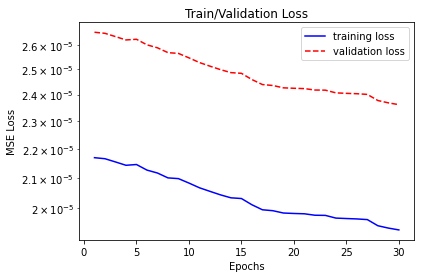

In [80]:
# PATH_PIC = os.path.join(os.getcwd(), "model_pic_points.pt")
PATH_PIC = os.path.join(os.getcwd(), "model_pic_spline.pt")

model_picture_trained = torch.load(PATH_PIC)

learning_rate = 1e-4

optimizer = optim.SGD(model_picture_trained.parameters(), lr=learning_rate)
epoch = 30

# 0 indicates edge points 1 indicates spline
train_picture(model_picture_trained, optimizer, epoch, 1)

### Visualization of outcomes

In [100]:
# testing cell for better viewing the length
train_x_pic_points, train_y_pic_points

print(len(train_x_pic_points))
print(train_x_pic_points[0].shape)
print(train_y_pic_points[0].shape)

39
torch.Size([512, 1, 82, 77])
torch.Size([512, 160])


Edge Point Model

In [137]:
PATH_PIC = os.path.join(os.getcwd(), "model_pic_points.pt")
model_picture_trained = torch.load(PATH_PIC)


rand1 = random.randint(0, len(test_x_pic_points)-1)
rand2 = random.randint(0, len(test_x_pic_points[rand1])-1)

print("current testing batch =", rand1)
print("current testing image =", rand2)

score_pic = prediction(model_picture_trained, test_x_pic_points[rand1][rand2].reshape(1, 1, 82, 77))

# Print all points out for viewing
# for num in range(len(test_y_pic_points[rand1][rand2])):
#     print(num+1, ": Ground Truths =", test_y_pic_points[rand1][rand2][num].item(), ", Prediction =", score_pic[0, num].item())


current testing batch = 1
current testing image = 365


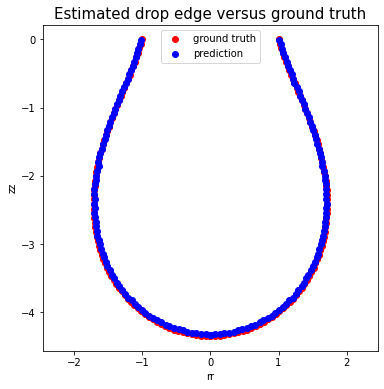

In [138]:
# scattering points for ground truth
x_gt_pos = test_y_pic_points[rand1][rand2][0:80]
y_gt_pos = test_y_pic_points[rand1][rand2][80:160]
x_gt_neg = -torch.flip(x_gt_pos, [0])
y_gt_neg = torch.flip(y_gt_pos, [0])
x_gt = torch.cat((x_gt_neg, x_gt_pos))
y_gt = torch.cat((y_gt_neg, y_gt_pos))

# scattering points for prediction
x_pred_pos = score_pic[0, 0:80]
y_pred_pos = score_pic[0, 80:160]
x_pred_neg = -torch.flip(x_pred_pos, [0])
y_pred_neg = torch.flip(y_pred_pos, [0])
x_pred = torch.cat((x_pred_neg, x_pred_pos))
y_pred = torch.cat((y_pred_neg, y_pred_pos))

# plotting
fig,ax = plt.subplots(1,1,figsize=(6, 6))
ax.set_title("Estimated drop edge versus ground truth", fontsize = 15)
plt.scatter(x_gt, y_gt, c="red", label="ground truth")
plt.scatter(x_pred, y_pred, c="blue", label="prediction")
# plt.imshow(test_x_pic_plot[rand1],cmap='gray',aspect='auto', extent=(-3.5,3.5,-7,0.1), interpolation ='bilinear')
plt.xlabel("rr")
plt.ylabel("zz")
plt.legend()
plt.axis('equal')
plt.show()

Spline Model Interpolation points

In [111]:
#Number of interpolation points to use for PhysicsNet and plotting
Num_points = 80

# Load YC matrix for point values and s data for interpolation
data_s = pd.read_csv("Data_uniform/s.csv", header= None)

s = data_s.values
s = s.reshape(1,len(s))

# Interpolate to 160 points using a linear vector for s
ss = np.linspace(s[0][0],s[0][-1],Num_points)

data_YC = pd.read_csv("Data_uniform/YC.csv", header= None)
YC = torch.Tensor(data_YC.values)

Plot difference Spline and ground truth

In [141]:
PATH_PIC = os.path.join(os.getcwd(), "model_pic_spline.pt")
model_picture_trained = torch.load(PATH_PIC)


rand1 = random.randint(0, len(test_x_pic_spline)-1)
rand2 = random.randint(0, len(test_x_pic_spline[rand1])-1)

print("current testing batch =", rand1)
print("current testing image =", rand2)

score_pic_pred = prediction(model_picture_trained, test_x_pic_spline[rand1][rand2].reshape(1, 1, 82, 77))

#Multiply the found Chebyshev coefficients with YC matrix to obtain edge points
score_pic_r = torch.matmul(YC ,score_pic_pred[0, 0:11]) 
score_pic_z = torch.matmul(YC ,score_pic_pred[0, 11:22])

#Do polynominal fitting through data to get more data points
score_pic_r = np.polyval(np.polyfit(s[0],score_pic_r.numpy(),15), ss)
score_pic_z = np.polyval(np.polyfit(s[0],score_pic_z.numpy(),15), ss)

#Convert back to torch
score_pic_r = torch.tensor(score_pic_r)
score_pic_z = torch.tensor(score_pic_z)


test_y_pic_r = torch.matmul(YC ,test_y_pic_spline[rand1][rand2][0:11].float()) 
test_y_pic_z = torch.matmul(YC ,test_y_pic_spline[rand1][rand2][11:22].float()) 

#Do polynominal fitting through data to get more data points
test_y_pic_r = np.polyval(np.polyfit(s[0],test_y_pic_r.numpy(),15), ss)
test_y_pic_z = np.polyval(np.polyfit(s[0],test_y_pic_z.numpy(),15), ss)

#Convert back to torch
test_y_pic_r = torch.tensor(test_y_pic_r)
test_y_pic_z = torch.tensor(test_y_pic_z)

# Print all points out for viewing
# for num in range(len(test_y_pic_r)):
#    print(num+1, ": Ground Truths =", test_y_pic_z[num].item(), ", Prediction =", score_pic_z[num].item())


current testing batch = 0
current testing image = 155


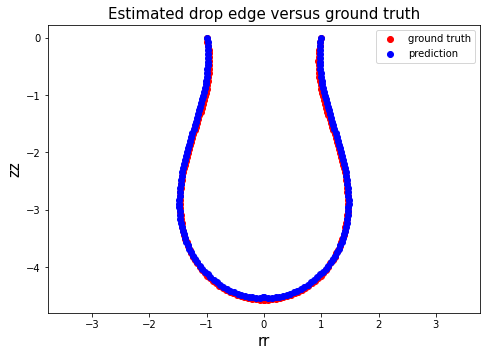

In [142]:
# scattering points for ground truth
gt_r_pos = test_y_pic_r
gt_r_neg = -torch.flip(test_y_pic_r, [0])
gt_z_pos = test_y_pic_z
gt_z_neg = torch.flip(test_y_pic_z, [0])
gt_r = torch.cat((gt_r_neg, gt_r_pos))
gt_z = torch.cat((gt_z_neg, gt_z_pos))

# scattering points for prediction
pred_r_pos = score_pic_r
pred_r_neg = -torch.flip(score_pic_r, [0])
pred_z_pos = score_pic_z
pred_z_neg = torch.flip(score_pic_z, [0])
pred_r = torch.cat((pred_r_neg, pred_r_pos))
pred_z = torch.cat((pred_z_neg, pred_z_pos))

# plotting
fig = plt.figure()
a1 = fig.add_axes([0,0,1,1])
a1.set_xlim(0,3)
a1.set_title("Estimated drop edge versus ground truth", fontsize = 15)
plt.scatter(gt_r, gt_z, c="red", label="ground truth")
plt.scatter(pred_r, pred_z, c="blue", label="prediction")

plt.xlabel("rr",fontsize = 15)
plt.ylabel("zz",fontsize = 15)
plt.legend()
plt.axis('equal')
plt.show()

### Evaluation between two model predictions

In [143]:
# Edge Points -> x_gt, y_gt, x_pred, y_pred
# Spline -> gt_r, gt_z, pred_r, pred_z

l2_x_points = torch.sum(torch.pow((x_gt - x_pred), 2))
l2_y_points = torch.sum(torch.pow((y_gt - y_pred), 2))
l2_points = (l2_x_points + l2_y_points) / len(x_gt)
print("L2 norm of point =", l2_points.item())

l2_x_spline = torch.sum(torch.pow((gt_r - pred_r), 2))
l2_y_spline = torch.sum(torch.pow((gt_z - pred_z), 2))
l2_spline = (l2_x_spline + l2_y_spline) / len(gt_r)
print("L2 norm of spline =", l2_spline.item())

L2 norm of point = 0.00035236273185931946
L2 norm of spline = 0.0005008339329800081


# Squential testing

## Reload dataset for the alignment

In [12]:
# converting the list to numpy array
train_x_test = np.array(train_img)
train_y_test = data_image_spline.iloc[0:,0:2].values

train_x_test, train_y_test, val_x_test, val_y_test, test_x_test, test_y_test = \
    split_n_transfer(train_x_test, train_y_test)

train_x_test, train_y_test, val_x_test, val_y_test, test_x_test, test_y_test = \
    batch_all(train_x_test, train_y_test, val_x_test, val_y_test, test_x_test, test_y_test)

print(len(train_x_test), len(train_y_test), len(val_x_test), len(val_y_test), len(test_x_test), len(test_y_test))

39 39 5 5 5 5


## Call PictureNet and get prediction for PhysicsNet

In [13]:
# load model
PATH_PIC = os.path.join(os.getcwd(), "model_pic_spline.pt")
model_picture_trained = torch.load(PATH_PIC, map_location='cpu')

# transfer from batches back into one
for i in range(len(test_x_test)):
    if i == 0:
        x_test = test_x_test[i]
        y_test = test_y_test[i]
        counter = True
    else:
        x_test = torch.cat([x_test, test_x_test[i]], dim=0)
        y_test = torch.cat([y_test, test_y_test[i]], dim=0)

# cropping bc not enough memory
x = x_test[0:2000, :, :, :]
y = y_test[0:2000, :]

# make prediction
test1 = model_picture_trained(x)
print(test1.shape)

torch.Size([2000, 22])


Spline Model Interpolation points

In [14]:
#Number of interpolation points to use for PhysicsNet and plotting
Num_points = 80

# Load YC matrix for point values and s data for interpolation
data_s = pd.read_csv("Data_uniform/s.csv", header= None)

s = data_s.values
s = s.reshape(1,len(s))

# Interpolate to 160 points using a linear vector for s
ss = np.linspace(s[0][0],s[0][-1],Num_points)

data_YC = pd.read_csv("Data_uniform/YC.csv", header= None)
YC = torch.Tensor(data_YC.values)


Transfer the model 1 output from coef to points as model 2 input

In [15]:
# transfer coef to 160 edge points for training
x_1 = []
x_2 = []
for i in range(len(test1)):
    x_1_temp = torch.matmul(YC, test1[i, 0:11]) 
    x_2_temp = torch.matmul(YC, test1[i, 11:22])
    x_1.append(np.polyval(np.polyfit(s[0], x_1_temp.detach().numpy(), 15), ss))
    x_2.append(np.polyval(np.polyfit(s[0], x_2_temp.detach().numpy(), 15), ss))
test2 = torch.tensor(np.append(x_1, x_2, axis=1), dtype=torch.float32)

print(test2.shape)

torch.Size([2000, 160])


## Call PhysicsNet and get prediction for tension

In [16]:
# load model
PATH_CAL = os.path.join(os.getcwd(), "model_cal_points.pt")
model_physics_trained = torch.load(PATH_CAL, map_location='cpu')

# make prediction
test3 = model_physics_trained(test2)
print(test3.shape)
print(test3[1:10])
print(y[1:10])

torch.Size([2000, 2])
tensor([[36.3540, 10.4151],
        [31.2064, 14.5445],
        [28.0102,  9.2738],
        [55.5957, 19.7900],
        [55.8721, 19.6352],
        [19.7622,  8.4336],
        [56.8143, 24.8308],
        [75.7383, 34.2525],
        [83.8912, 25.3214]], grad_fn=<SliceBackward0>)
tensor([[36.7000, 10.3445],
        [30.3000, 14.6665],
        [28.0000,  9.1239],
        [55.4000, 19.8969],
        [56.0000, 19.7042],
        [19.4000,  8.6784],
        [57.0000, 25.3034],
        [77.7000, 34.9131],
        [85.9000, 25.7671]], dtype=torch.float64)


## Print results

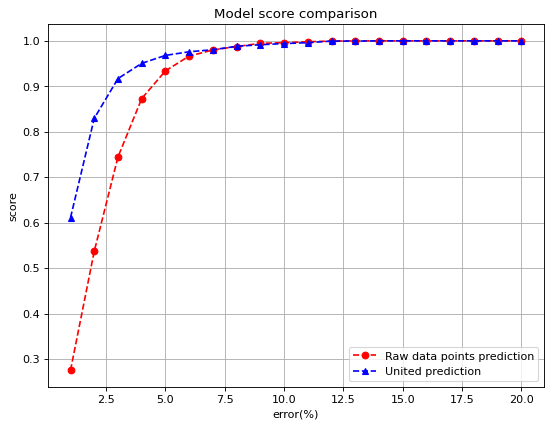

In [21]:
PATH_ONE = os.path.join(os.getcwd(), "model_one.pt")
model_one_trained = torch.load(PATH_ONE, map_location='cpu')

test_one = model_one_trained(x)

# set error margin to count as accurate
error_list = torch.linspace(0.01, 0.20, steps=20)

def score_cal(x, y, error):
    diff = ~abs((x-y)/y).gt(error) 
    count = diff[:, 0]
    return count.sum()/len(count)

score_list_test = []
score_list_united = []
for i in range(len(error_list)):
    score_list_test.append(score_cal(test3, y, error_list[i]).item())
    score_list_united.append(score_cal(test_one, y, error_list[i]).item())

# print("Score of raw data points prediction (two-model solution) =", score_list_test) 
plt.figure(figsize=(8, 6), dpi=80)
plt.plot(error_list*100 , score_list_test, 'or--', label='Raw data points prediction')
plt.plot(error_list*100 ,score_list_united, '^b--', label='United prediction')
plt.xlabel('error(%)')
plt.ylabel('score')
plt.title('Model score comparison')
plt.grid()
plt.legend()